In [1]:
##dataset_id = "44_gain_scan_Lgadtrigger_Int2kHz_30CO2"

dataset_id = "50_trigg_lgad_channel8_g4_Lgadtri_Int5kHz_30CO2"

# set data taking time in seconds for each step, minimum 90s is needed to initialize and get some trigger from dabc stream
data_taking_duration = 60*30

# MDC settings:
HVlist = [  1750 ]

# set PASTTREC settings:
# peakintime: 10, 15, 20 (ns)
# gain: 1, 2, 4
# threshold: 1,2,3 .... 127
# spike rejection 10 ,15, 20 ,33,99 all int possible (ns)
####  SettingA :
#ptime_list = [ 10,15,20 ]
#pt_gain_list = [ 1,2,4  ]
# pt_gain_list = [ 2 ]
#pt_threshold_list = [10]
# spike_reject_list_TDC = [0]

####  SettingZ(p15g2th10) :
#ptime_list = [ 10,15,20 ]
#pt_gain_list = [ 2 ]
#pt_threshold_list = [ 10 ]
#spike_reject_list_TDC = [0]
####  SettingC :
# ptime_list = [ 10 ]
# pt_gain_list = [ 2  ]
# pt_threshold_list = [ 9 ]
# spike_reject_list_TDC = [0]
import db
import os
# activate coincidence trigger only:
#os.system("trbcmd w 0xc035 0xa101 0xffff0800")
# activate scintillator1 trigger (ch49) only:
#os.system("trbcmd w 0xc035 0xa101 0xffff0400")  # trg_channel_mask: edge=1111 1111 1111 1111, mask=0000 0100 0000 0000

    
##################################



ptime_list = [10]
# set PASTTREC default threshold for the measurement
#pt_gain_list = [ 2  ]
pt_gain_list = [4]  
pt_threshold_list = [4]
#pt_threshold_list = [ 10 ]
#pt_threshold_list = [1,2,3,4,5,6,7,10]
# pt_threshold_list = [7 ]
spike_reject_list = [0]
spike_reject_list_TDC = [0]
#spike_reject_list_TDC = [0,1,2,3,4,5,6,7,8]

#boards_scan_list =   [ "0902","0902","0902","0902"  ]
boards_scan_list =  [ "80053" , "80053"]
#db.board_list(); 
if data_taking_duration < 90:
    data_taking_duration = 90
    
if data_taking_duration< 90:
    wait_for_beam = True
else:
    wait_for_beam = False
#time windows:
t1_min = -1500
t1_max = 0
#t1_min = -5000
#t1_max = 5000
#1. scintillator upstream
ref_channel = 35049
#2. scintillator downstream
#ref_channel = 35050

spillbreak_rate_scintillator = 3000
#board_list = [ "80053" , "80054" ,"80081" ,"80082" ]

board_list =  db.board_list(); 
boards_to_activate_on_one_step = 1
TDClist = ["0x1807","0x1812","0x1806","0x1813","0350"]
number_of_TDC_channels = 10
channellist = [48,49]
#time trend:
trendduration = 1*60*60
stepduration = 60

name = board_list[0]

#os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1800", 2))
#os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1803", 0))
# COSY May2021 beam position:
#os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1801", 0))
#os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1802", 2))
#setTDC spike rejection to ~50ns 
#os.system("trbcmd loadbit 0x1801 0xd580 0xf0000000 0x70000000")

#switch off DCDC converter nex to TDC1802 & 1803, which is there to check influence on noise
import hameg_lv as hMBO 

## define sequence of boards to activate in scan.
#boards_scan_list = board_list

total_measure_duration = data_taking_duration*len(spike_reject_list)*len(spike_reject_list_TDC)*len(ptime_list)*len(pt_gain_list)*len(pt_threshold_list)*len(boards_scan_list)/boards_to_activate_on_one_step*len(HVlist)
message = " total time estimated [h] = {:.2f} = [min] = {:.2f} ".format(total_measure_duration/3600,total_measure_duration/60)
print(message)


 total time estimated [h] = 1.00 = [min] = 60.00 


In [2]:
def beep(): 
    import IPython.display as ipd
    import numpy
    t = numpy.linspace(0, 0.5, int(0.6*24090), endpoint=False) # time variable
    x = 0.5*numpy.sin(2*numpy.pi*550*t)    
    ipd.Audio(x, rate=24090, autoplay=True) # load a NumPy array  


import ROOT
import os
from my_utils import *
set_width_max_of_jupyterpad()

from fst import *
import numpy as np
import db 
import pasttrec_ctrl as ptc
import baseline_calib

data_dir = make_data_dir()

#from ROOT import gInterpreter, gSystem
#gInterpreter.ProcessLine('#include "/workdir/my_event.h"')

import tdc_daq as td


print(data_dir)
for my_board in db.board_list():
    db.enable_board(my_board)    
    #db.unset_standby_board(my_board)
#     db.set_standby_board(my_board)    
    #db.disable_board(my_board)
#     ptc.init_board_by_name(my_board)
#     ptc.set_threshold_for_board_by_name(my_board,5)

ptc.init_active_boards()
td.enable_tdc_channels_of_active_boards()

#set spike rejection for pasttrec tdc channels:
#setup = db.get_setup_json()
#setup["global_settings"]["spike_rejection"] = 33
#print( setup["global_settings"]["spike_rejection"] )
#db.write_setup_json(setup)
#db.write_go4_settings_h()


Welcome to JupyROOT 6.14/04


/workdir/jupyter/Cosy2021Nov_tot_data_taking_data


In [3]:
##################################################
##   clear data dir, copy root file or measure fresh    ##
##################################################
import hameg_trb 
import os 
import time
import scalers
import IPython.display as ipd
import numpy
t = numpy.linspace(0, 0.5, int(0.6*24090), endpoint=False) # time variable
x = 0.5*numpy.sin(2*numpy.pi*550*t)    
        
# boards_scan_list = ['0110', '0011', '0010', '0015', '0016', '0009', '0017', '0020', '0023', '0030', '0110', '0029', '0002', '0027', '0101', '0025', '0004', '0026', '0022', '0003', '0014', '0021', '0018', '0104', '0006', '0028', '0103', '0102', '0008', '0005']
#boards_scan_list = ['0010', '0101', '0011', '0002', '0009', '0004', '0015', '0027', '0016', '0025', '0017', '0026', '0022', '0020', '0003', '0023', '0030', '0014', '0021', '0029', '0018', '0104', '0103', '0006', '0008', '0102', '0028']
#boards_scan_list = ['0010', '0011', '0009', '0015', '0016', '0017', '0020', '0023', '0030', '0029', '0101', '0002', '0004', '0027', '0025', '0026', '0022', '0003', '0014', '0021', '0018', '0104', '0006', '0028']
# boards_scan_list = ['0010', '0009', '0011', '0015', '0016', '0017', '0020', '0023', '0030', '0029', '0027', '0002', '0004', '0025', '0026', '0022', '0003', '0014', '0021', '0018', '0006', '0028', '0008', '0005']
#boards_scan_list = ['0014', '0005', '0021', '0022', '0025', '0003', '0026', '0027', '0008', '0004', '0002', '0101', '0029', '0030', '0028', '0023', '0020', '0017', '0016', '0006', '0015', '0010', '0011', '0009']

data_file_list = []
current_list = []
volt_list = []
current_list2 = []
volt_list2 = []

tdc_channels = list(range(0, number_of_TDC_channels))
scaler_list_trend_channel = [ []  for i in range(16)] 
scinti_rate = [[] for i in range(0,2)]
    
#for my_board in db.board_list():
#            db.unset_standby_board(my_board)
 
print(message)
alert(message)
#for timestep in range(0,ntimesteps):
for spike_reject in spike_reject_list:
 setup = db.get_setup_json()
 setup["global_settings"]["spike_rejection"] = spike_reject
 setup["global_settings"]["t1_L"] =     t1_min
 setup["global_settings"]["t1_R"] =     t1_max
 setup["global_settings"]["reference_channel"] =     ref_channel    
 db.write_setup_json(setup)
 db.write_go4_settings_h()

 for spike_reject_TDC in spike_reject_list_TDC:
 #setTDC spike rejection to ~50ns 
  #os.system("trbcmd loadbit 0x1801 0xd580 0xf0000000 0x{:d}0000000".format(spike_reject_TDC))

  for HV in HVlist:
  # for tdc in TDClist:
      #  print("trbcmd loadbit {} 0xd580 0x300 0x{}00".format(tdc, ptime))
   #     os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format(tdc, ptime))
   for ptime in ptime_list: 
    for pt_gain in pt_gain_list:     
     for pt_threshold in pt_threshold_list:    
      for my_board in db.board_list():
        db.set_standby_board(my_board)
      import random
      random.shuffle(boards_scan_list)
      iboard = -boards_to_activate_on_one_step
      for p in range(0,int(len(boards_scan_list)/boards_to_activate_on_one_step)): 
        if (p==0):
            os.system("trbcmd w 0x0350 0xdf00 0x80") 
            ## trigger on 1 LGAD channel only
        else:
            os.system("trbcmd w 0x0350 0xdf00 0xffff")
            ## trigger on all 16 LGAD channels
        iboard += boards_to_activate_on_one_step
        
        #alert(message)
        import IPython.display as ipd
        import numpy
        t = numpy.linspace(0, 0.5, int(0.6*24090), endpoint=False) # time variable
        x = 0.5*numpy.sin(2*numpy.pi*650*t)    
        ipd.Audio(x, rate=24090, autoplay=True) # load a NumPy array
        time.sleep(5)
               
        for my_board in db.board_list():
            for p_act in range(0,boards_to_activate_on_one_step):
                if my_board == boards_scan_list[iboard+p_act]:
                    db.unset_standby_board(my_board)
                    db.enable_board(my_board)
                    print("activate board: ",my_board)
        # enable data taking boards:
#         print("enable data taking boards")
        for my_board in board_list:
            db.unset_standby_board(my_board)
            db.enable_board(my_board)
        td.enable_tdc_channels_of_active_boards()
       # ptc.init_boards_by_name(db.board_list())    
        #ptc.init_active_boards()
#         print("init")
        ptc.init_boards_by_name(board_list, ptime, pt_gain, pt_threshold)   
                        # init_boards_by_name(board_list,pktime=-1,gain=-1,threshold=-1):
#         print("threshold")        
        for name in board_list:
            #baseline_calib.set_baselines_individual(name, [-15]*16 )   
            ptc.set_threshold_for_board_by_name(name,pt_threshold)
        # startr measurements, with spill start:
        if wait_for_beam:
                wait_for_spill_break(threshold_rate=spillbreak_rate_scintillator)
                wait_for_spill(threshold_rate=spillbreak_rate_scintillator)
#         print(hameg_trb.get_curr(3), hameg_trb.get_curr(4))
        scaler_rates = td.scaler_rate_of_TDC("0x1807",tdc_channels,5) 
        for ch in range(0,len(scaler_rates)):
                    scaler_list_trend_channel[ch] += [ scaler_rates[ch] ]
        #scaler_rates = td.scaler_rate_of_board(name,2) 
        #tdc_daq.scaler_rate(TDC,channels,scan_time)[ch]
        #take_data(events=20000)
        # uses only trigger by TDC 0350 channel 49 as the reference. 
        # either Scitillator inpot or puls generator input to this channel, needs to be used
        beep()
        print("start data taking: HV_{:d}, peaking time_{:d}, threshold_{:d}, gain_{:d} # of boards active_{:d}, offline spike rejection_{:d}, TDC spike rejection_{:d}".format(HV,ptime,pt_threshold,pt_gain,iboard,spike_reject,spike_reject_TDC))
        import datetime
   
        
#         upstream = scalers.scaler_rate("0x0350",[49],4)
#         downstream = scalers.scaler_rate("0x0350",[50],4)
        scaler_rates = td.scaler_rate("0x0350",channellist,30)
        for ch in range(0,len(scaler_rates)):
                scinti_rate[ch] += [ scaler_rates[ch] ]
        #print("beam intensity measured by scintillator rates: upstream ="+scinti_rate[0]+", downstream = "+downstream )
        data_file = "{:s}/ID{:s}_HV{:d}V_ptime_{:d}_thr_{:d}_gain_{:d}_boardsON_{:d}_sr_{:d}_srTDC_{:d}".format(data_dir,dataset_id,HV,ptime,pt_threshold,pt_gain,iboard,spike_reject,spike_reject_TDC)
        print("data file written: ", data_file)
        startttime=datetime.datetime.now()
        print("Starting now {:s} ".format(str(datetime.datetime.now())))
        start_hld_file(filename="{:s}.hld".format(data_file))
        take_data(time=data_taking_duration)
        print("stopped now {:s} ".format(str(datetime.datetime.now())))
        print(datetime.datetime.now()-startttime)
        #import time as time
        #time.sleep(5) # prevents crashing the trbsystem (probably only needed with high traffic, while low thresholds ...) 
        stop_hld_file()
        ipd.Audio(x, rate=24090, autoplay=True) # load a NumPy array
        
        current_list += [ hameg_trb.get_curr(3) ]
        volt_list += [ hameg_trb.get_volt(3) ]
        current_list2 += [ hameg_trb.get_curr(4) ]
        volt_list2 += [ hameg_trb.get_volt(4) ] 

        print(hameg_trb.get_curr(3), hameg_trb.get_curr(4))
     # clear_data_dir()
      
        #os.system("cp /workdir/tree_out.root {:s}".format(data_file))
        os.system("cp /workdir/joint_tree.root {:s}.root".format(data_file))
        os.system("cp /workdir/tree_out.root {:s}_tree_out.root".format(data_file))
        data_file_list.append(data_file)

  # write data file list to disk, for later analysis
import pickle
with open("{:s}/datasetID_{:s}_list.pickle".format(data_dir,dataset_id), 'wb') as fp:
    pickle.dump(data_file_list, fp)  
print(fp)

 total time estimated [h] = 1.00 = [min] = 60.00 


activate board:  80053
start data taking: HV_1750, peaking time_10, threshold_4, gain_4 # of boards active_0, offline spike rejection_0, TDC spike rejection_0
data file written:  /workdir/jupyter/Cosy2021Nov_tot_data_taking_data/ID50_trigg_lgad_channel8_g4_Lgadtri_Int5kHz_30CO2_HV1750V_ptime_10_thr_4_gain_4_boardsON_0_sr_0_srTDC_0
Starting now 2021-11-08 06:50:24.742293 
stopped now 2021-11-08 07:20:58.393663 
0:30:33.651521
0.2461 1.861
activate board:  80053
start data taking: HV_1750, peaking time_10, threshold_4, gain_4 # of boards active_1, offline spike rejection_0, TDC spike rejection_0
data file written:  /workdir/jupyter/Cosy2021Nov_tot_data_taking_data/ID50_trigg_lgad_channel8_g4_Lgadtri_Int5kHz_30CO2_HV1750V_ptime_10_thr_4_gain_4_boardsON_1_sr_0_srTDC_0
Starting now 2021-11-08 07:21:43.912126 
stopped now 2021-11-08 07:52:21.601286 
0:30:37.689329
0.2462 1.864
<_io.BufferedWriter name='/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/datasetID_50_trigg_lgad_channel8_g4_Lgad

>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reache

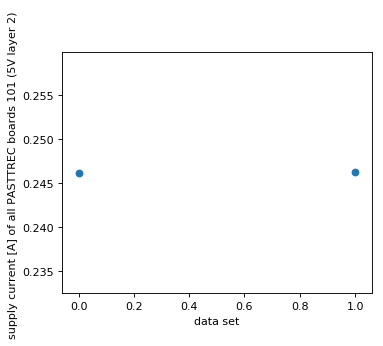

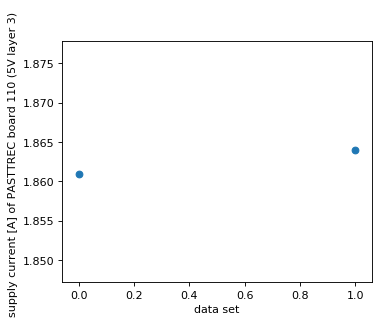

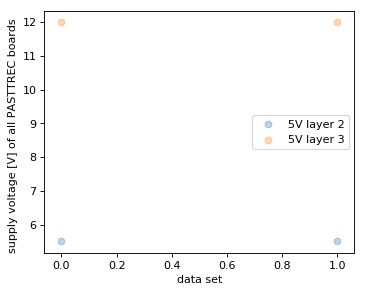

In [4]:

from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k')        
plt.scatter(range(0,len(current_list)),current_list)    
plt.xlabel("data set")
plt.ylabel("supply current [A] of all PASTTREC boards 101 (5V layer 2) ")
plt.show()
plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(current_list2)),current_list2)        
plt.xlabel("data set")
plt.ylabel("supply current [A] of PASTTREC board 110 (5V layer 3) ")
plt.show()

plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(volt_list)),volt_list,alpha=0.3,label = "5V layer 2")
plt.scatter(range(0,len(volt_list2)),volt_list2,alpha=0.3,label = "5V layer 3")      
plt.xlabel("data set")
plt.ylabel("supply voltage [V] of all PASTTREC boards  ")
plt.legend()
plt.show()

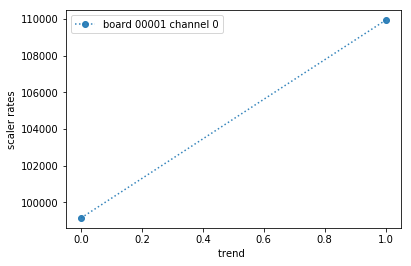

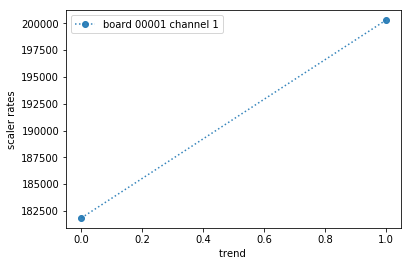

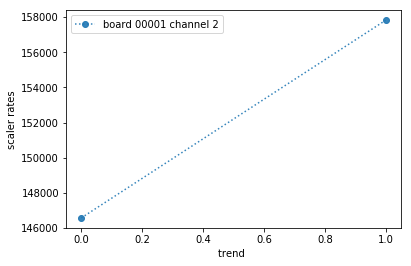

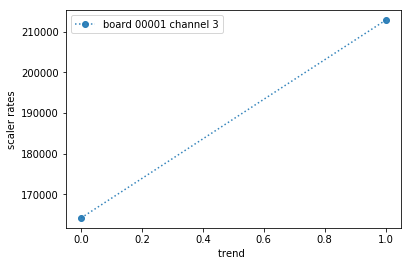

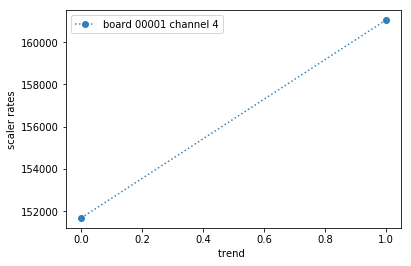

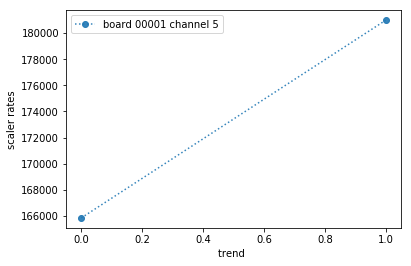

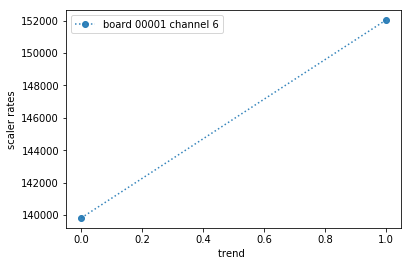

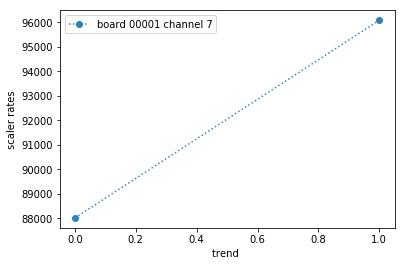

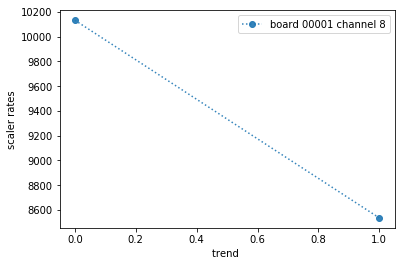

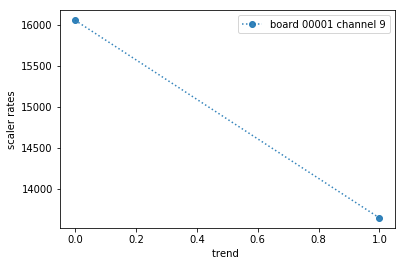

No handles with labels found to put in legend.


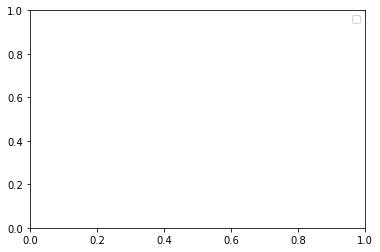

No handles with labels found to put in legend.


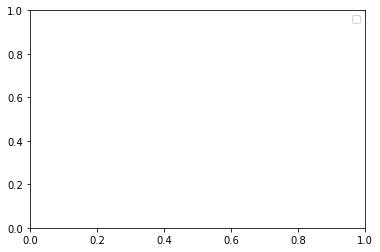

No handles with labels found to put in legend.


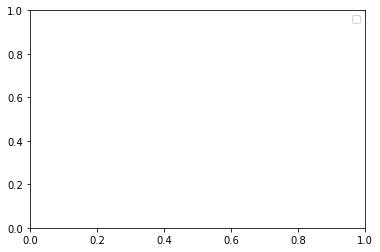

No handles with labels found to put in legend.


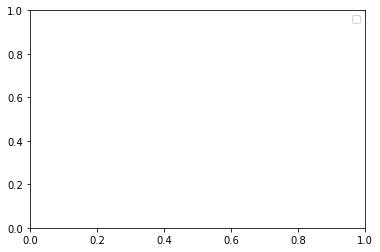

No handles with labels found to put in legend.


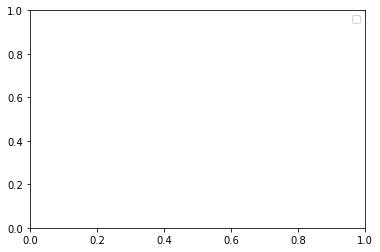

No handles with labels found to put in legend.


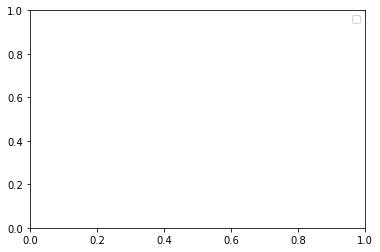

In [5]:
 
for ch in range(0,len(scaler_list_trend_channel)):
    if scaler_list_trend_channel[ch]:
            plt.errorbar(range(0,len(scaler_list_trend_channel[ch])),scaler_list_trend_channel[ch], yerr=None, xerr=None, fmt='o:', alpha=0.9,label = "board {:s} channel {:d}".format(name,ch))
            plt.xlabel("trend ")
            plt.ylabel("scaler rates")  
    plt.legend()
    plt.show()

In [6]:
  # write data file list to disk, for later analysis
import pickle 
with open("{:s}/datasetID_{:s}_list.pickle".format(data_dir,dataset_id), 'wb') as fp:
    pickle.dump(data_file_list, fp)  
print(fp)
alert("finished")
#data_file_list = pickle.load(fp) 

<_io.BufferedWriter name='/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/datasetID_50_trigg_lgad_channel8_g4_Lgadtri_Int5kHz_30CO2_list.pickle'>


In [7]:
# archive(label="ID_{:s}_tot_data_cosy2021_lena_newMBOs".format(dataset_id))


# list_file ="/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/datasetID_06_b_hvscan_SettingB_highintens_list.pickle"

# if ".pickle" in list_file:
#     with open (list_file,'rb') as fp:
#      data_file_list = pickle.load(fp) 
# # print(data_file_list)

# list_file ="/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/datasetID_06_hvscan_SettingB_highintens_list.pickle"

# if ".pickle" in list_file:
#     with open (list_file,'rb') as fp:
#      data_file_list += pickle.load(fp) 
    
# print(data_file_list)

data file   , tot_mostprob signalcounts noisecounts sn_ratio significance
/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/ID50_trigg_lgad_channel8_g4_Lgadtri_Int5kHz_30CO2_HV1750V_ptime_10_thr_4_gain_4_boardsON_0_sr_0_srTDC_0
/workdir/jupyter/Cosy2021Nov_tot_data_taking_data/ID50_trigg_lgad_channel8_g4_Lgadtri_Int5kHz_30CO2_HV1750V_ptime_10_thr_4_gain_4_boardsON_1_sr_0_srTDC_0


Warning in <TClass::Init>: no dictionary for class Event is available
Warning in <TClass::Init>: no dictionary for class Hit is available


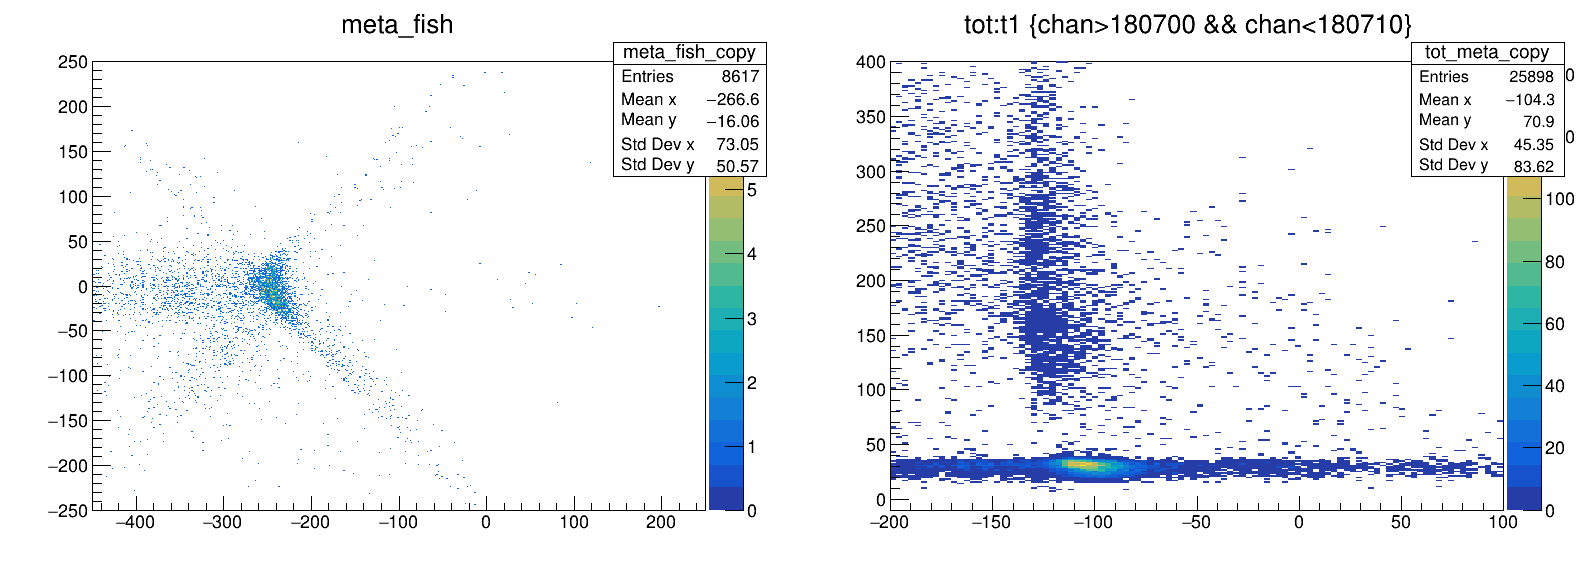

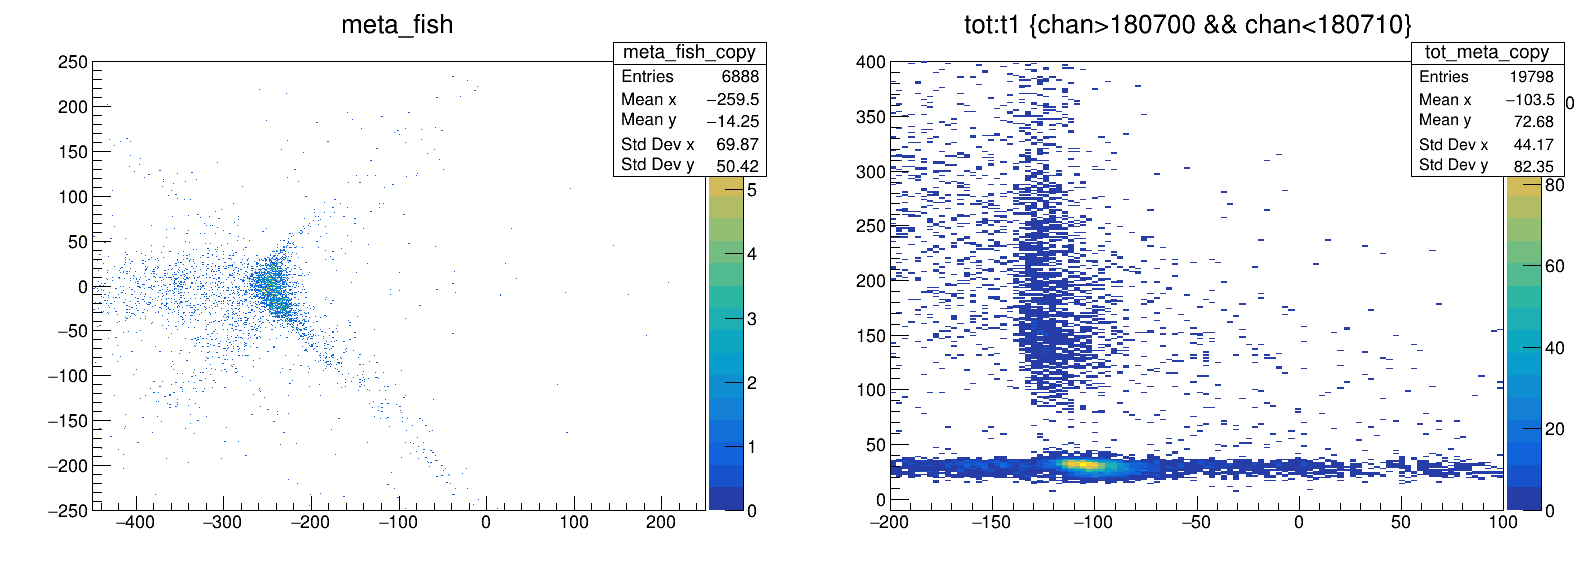

In [ ]:

##################################################
##               slurp root file                ##
##################################################
 
#with open ('/workdir/jupyter/tot_data_taking_data/HV1600V_ptime_15_threshold_50_gain_4_boardsON_23.rootlist.pickle', 'rb') as fp:

counts=[]

#f = ROOT.TFile("/workdir/tree_out.root".format(data_dir))
#tree = f.Get("TDC_1503")
#print("data entries TDC_1503: " + str(tree.GetEntries()))
i = -1
clist = [None]*100
print("data file   ,", "tot_mostprob", "signalcounts", "noisecounts", "sn_ratio", "significance")
    
for data_file in data_file_list:
    i += 1
    print(data_file)
    f = ROOT.TFile("{:s}.root".format(data_file))
    #f = ROOT.TFile("{:s}".format("/workdir/tree_out.root"))    
    tree = f.Get("joint_tree")
    #tree = f.Get("TDC_1807")
    #print("data entries: " + str(tree.GetEntries()))
    ## plot data:
    clist[i] = ROOT.TCanvas("myCanvasName"+str(i),str(data_file),1600,600)
    clist[i].Divide(2,1)
    clist[i].cd(1)    
   
    #clist[i].cd(1).SetLogy()

    fish = f.Get("meta_fish")
 
    #fish.GetXaxis().SetRangeUser(-200,-100)
   # fish.GetYaxis().SetRangeUser(-50,50)
    fish.DrawCopy("colz")
    clist[i].Draw()
    clist[i].cd(2)      
    tdc=1807
    disp_channels = 10
    tree.Draw("tot:t1>>tot_meta(100,-200,100,300,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels),"colz")
    potato = f.Get("tot_meta")
    potato.DrawCopy("colz")

    #fish = f.Get("coinc_matrix")
#    fish = f.Get("0x1807_potato")
#    fish.GetXaxis().SetRangeUser(-200,100)
#    fish.GetYaxis().SetRangeUser(50,500)
#     counts.append(fish.GetEntries())
    
    #fish.DrawCopy("colz")
#
 #   tree.Draw("trig_no>>triggmdc(100,0,1e9)","chan == 180706") 
  #  triggmdc = f.Get("triggmdc")
   # counts.append(triggmdc.GetEntries()/trigcounts)
    #triggmdc.DrawCopy("colz")
    clist[i].Draw()
    
    

In [ ]:
plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(counts)),counts)
plt.xlabel("HV / V")
plt.ylabel(" counts  ")
 


plt.show()

In [ ]:
import IPython.display as ipd
import numpy
t = numpy.linspace(0, 0.5, int(0.6*24090), endpoint=False) # time variable
x = 0.5*numpy.sin(2*numpy.pi*550*t)    
ipd.Audio(x, rate=24090, autoplay=True) # load a NumPy array

#### 

In [11]:



archive(label="ID_{:s}_tot_data_cosy2021_sandra_oldTDC".format(dataset_id))


archived to ./archive/2021-11-08_07-52-28_Cosy2021Nov_tot_data_taking_ID_50_trigg_lgad_channel8_g4_Lgadtri_Int5kHz_30CO2_tot_data_cosy2021_sandra_oldTDC
